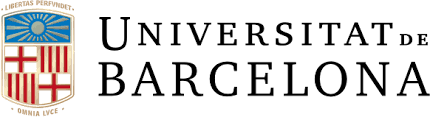

##*Master en Big Data & Data Science*

### **TFM: Clasificación de enfermedades en imágenes médicas utilizando técnicas de Deep Learning**
---

**Alumnos:**
* Santiago Rico Bartolome
* Claudia Alcazar Ureña
* Andres Villa
* Steve Solano Bermudez

**Profesor Tutor:** Ferran Arroyo Vendrell

# Preparacion del Entorno

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils
from sklearn.metrics import confusion_matrix, classification_report

**Montaje de Google Drive:** Se monta la unidad de Google Drive para acceder a los directorios de entrenamiento y prueba que contienen las imágenes.

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Directorios en local
train_dir = '/content/drive/MyDrive/Training'
test_dir = '/content/drive/MyDrive/Testing'

In [ ]:
# Paleta de colores en tonos rojos para la matriz de confusion
cmap = sns.color_palette("Reds")
# Propiedades de las imagenes a usar
batch_size = 32
img_height = 180
img_width = 180

# Preparacion de los Datos

In [ ]:
# Creacion del set de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5752 files belonging to 4 classes.
Using 4602 files for training.


In [ ]:
# Creacion del set de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5752 files belonging to 4 classes.
Using 1150 files for validation.


In [ ]:
# imprimimos las etiquetas
class_names = train_ds.class_names
print(class_names)

['glioma', 'meningioma', 'notumor', 'pituitary']


**Visualizacion de algunas imagenes**

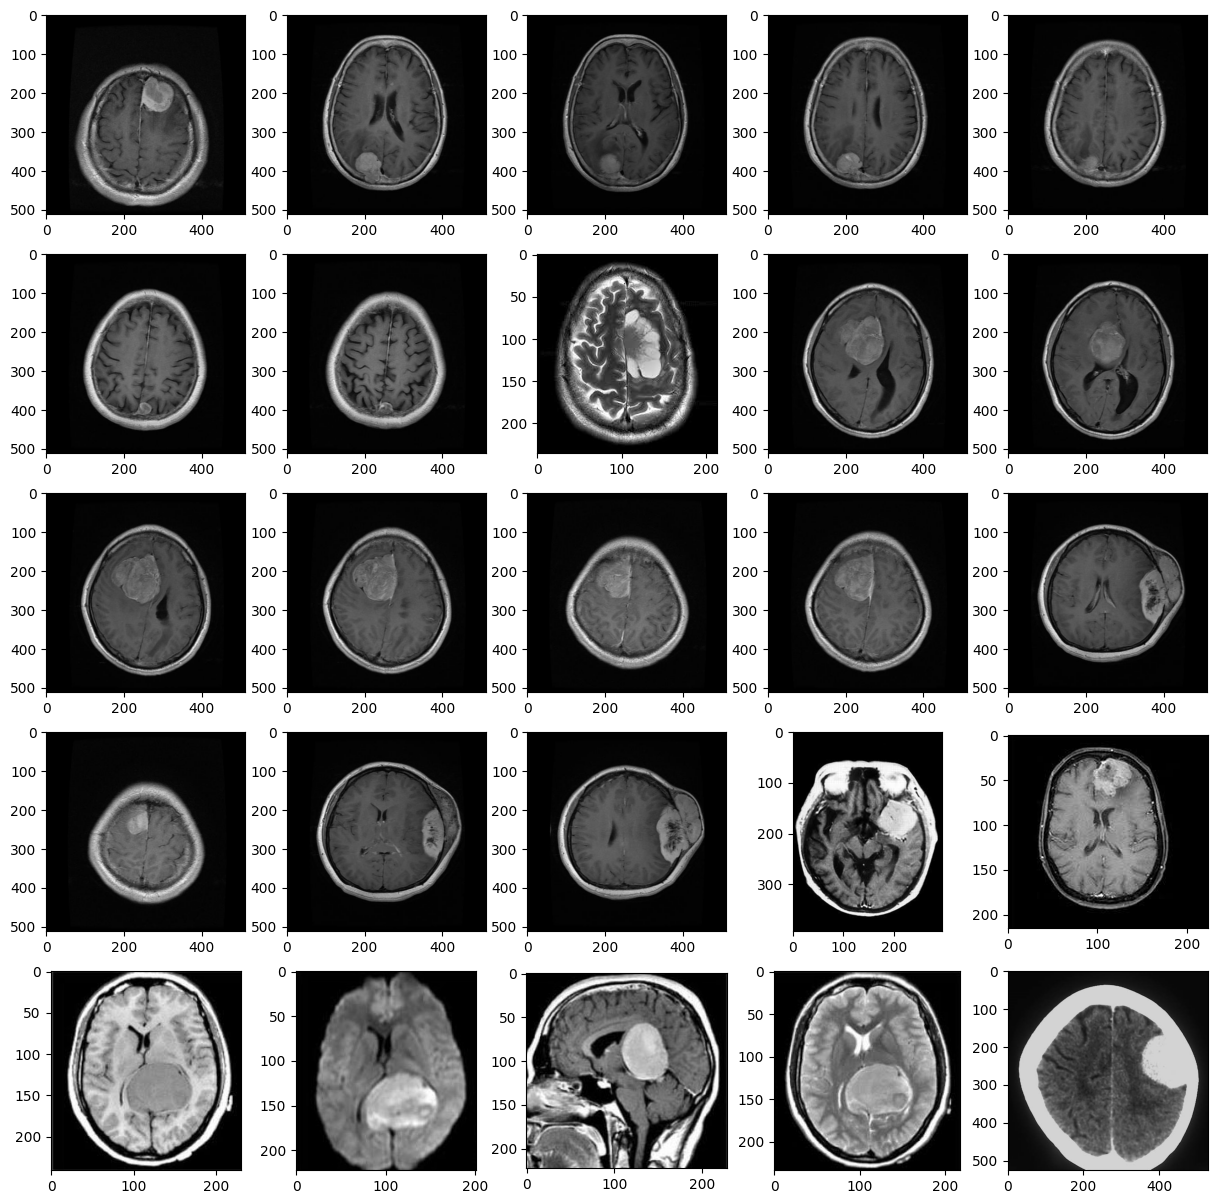

In [ ]:
#Mostrar algunas imagenes con pyplot, en este caso: 'Meningiomas'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

folder = '/content/drive/MyDrive/Training/meningioma'
images = os.listdir(folder)

for i, nameimg in enumerate(images[:25]):
  plt.subplot(5,5,i+1)
  image = mpimg.imread(folder + '/' + nameimg)
  plt.imshow(image)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Uso de la tecnica *Data Augmentation*

In [ ]:
# Escalacion de los pixeles en el rango de 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# flip, rotate and zoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

  ]
)

**Visualizacion de Imagenes despues de Data Augmentation**

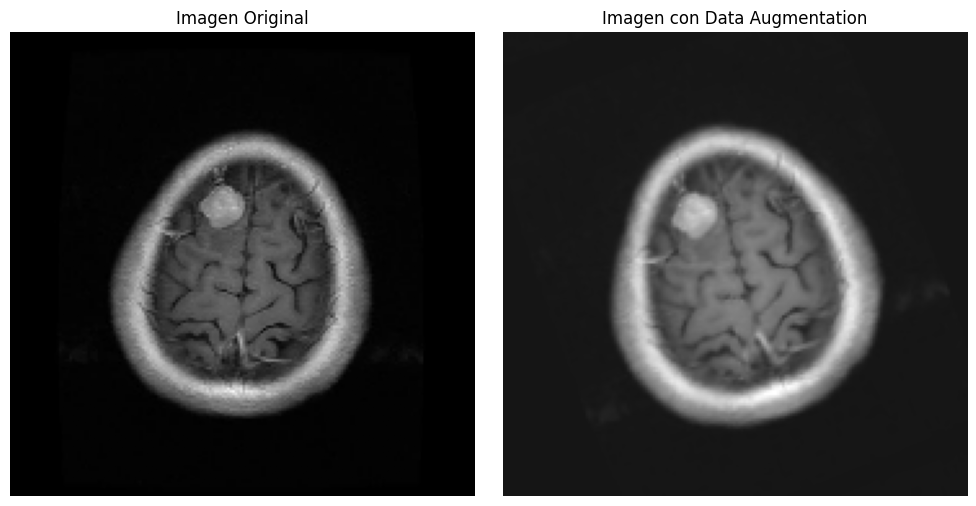

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config

# Habilitar el comportamiento de numpy en TensorFlow
np_config.enable_numpy_behavior()

# Obtener una imagen al azar del conjunto de entrenamiento
random_class = random.choice(class_names)
random_class_dir = os.path.join(train_dir, random_class)
random_image_path = random.choice(os.listdir(random_class_dir))
image_path = os.path.join(random_class_dir, random_image_path)

# Cargar la imagen original y redimensionarla
image = load_img(image_path, target_size=(img_height, img_width))
image_array = img_to_array(image)

# Aplicar data augmentation a la imagen
augmented_image_array = data_augmentation(np.expand_dims(image_array, 0))
augmented_image = augmented_image_array[0]

# Normalizar los valores de píxeles al rango [0, 1]
image_array /= 255.0
augmented_image /= 255.0

# Mostrar la imagen original y la imagen con data augmentation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_array)
axes[0].set_title("Imagen Original")
axes[0].axis("off")
axes[1].imshow(augmented_image)
axes[1].set_title("Imagen con Data Augmentation")
axes[1].axis("off")

plt.tight_layout()
plt.show()





**Resumen de Transformaciones usadas durante Data Augmentation**

In [ ]:
print(data_augmentation.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 180, 180, 3)      0         
 rast)                                                           
                                                                 
 random_brightness (RandomBr  (None, 180, 180, 3)      0         
 ightness)                                                       
                                                        

# Entrenamiento del Modelo

In [ ]:
# Cracion del modelo con Redes Neuronales Convolucionales (CNN)
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
    #layers.Dense(num_classes, activation='softmax', name="outputs")

])

In [ ]:
# Compilar
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

#model.compile(optimizer='adam',
              #loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              #metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

# Early Stopping

Se utiliza la tecnica de Early Stopping

El "early stopping" es una estrategia que permite detener el entrenamiento del modelo antes de completar todas las épocas (iteraciones) previstas si no se observa una mejora en el desempeño del modelo en el conjunto de validación. Esto evita el sobreajuste y ayuda a encontrar el punto óptimo en el que el modelo generaliza mejor

In [ ]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/TFM_CNNv2.h5"
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=4,
    restore_best_weights=True
)

In [ ]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
#  modelo guardado con los mejores pesos (determinados por el "early stopping") se guarda nuevamente en un archivo llamado "TFM_CNN.h5" en el directorio actual
model.save("TFM_CNNv2.h5")

Epoch 1/20
144/144 [==============================] - 733s 3s/step - loss: 0.9145 - accuracy: 0.6080 - val_loss: 0.6437 - val_accuracy: 0.7574
Epoch 2/20
144/144 [==============================] - 234s 2s/step - loss: 0.6727 - accuracy: 0.7299 - val_loss: 0.5941 - val_accuracy: 0.7609
Epoch 3/20
144/144 [==============================] - 234s 2s/step - loss: 0.6054 - accuracy: 0.7505 - val_loss: 0.5402 - val_accuracy: 0.7922
Epoch 4/20
144/144 [==============================] - 227s 2s/step - loss: 0.5513 - accuracy: 0.7844 - val_loss: 0.4601 - val_accuracy: 0.8278
Epoch 5/20
144/144 [==============================] - 235s 2s/step - loss: 0.4746 - accuracy: 0.8127 - val_loss: 0.4749 - val_accuracy: 0.8270
Epoch 6/20
144/144 [==============================] - 232s 2s/step - loss: 0.4514 - accuracy: 0.8205 - val_loss: 0.4352 - val_accuracy: 0.8452
Epoch 7/20
144/144 [==============================] - 231s 2s/step - loss: 0.4134 - accuracy: 0.8366 - val_loss: 0.3823 - val_accuracy: 0.8643

# Curvas de Rendimiento

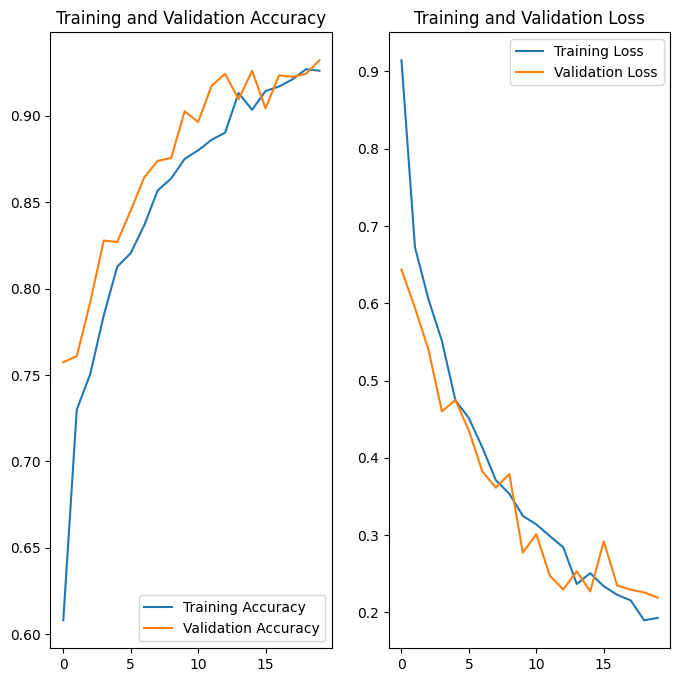

In [ ]:
# Grafico de las curva de entrenamiento: train y validation accuracy & loss
epochs = len(history.epoch) # epochs completadas por el early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Grafica training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafica training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluacion del Modelo

In [ ]:
# Lectura del Set de Entrenamiento
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)

Found 1351 files belonging to 4 classes.


**Predicciones**

In [ ]:
#Predicciones en el set de Testing
predictions = model.predict(test_ds)
# Se usa tf.nn.softmax ya que se aplico padding en training y al ser un problema multiclase o multinomial
# prediction. Threfore, we used `CategoricalCrossentropy` in model.compile()
scores = tf.nn.softmax(predictions[:])

43/43 [==============================] - 21s 450ms/step


In [ ]:
for i in range(10):
    print(
        "La imagen corresponde a {} con un {:.2f} porcentage de confianza."
        .format(class_names[np.argmax(scores[i])], 100 * np.max(scores[i]))
    )


La imagen corresponde a notumor con un 99.96 porcentage de confianza.
La imagen corresponde a glioma con un 58.73 porcentage de confianza.
La imagen corresponde a pituitary con un 98.75 porcentage de confianza.
La imagen corresponde a notumor con un 99.77 porcentage de confianza.
La imagen corresponde a pituitary con un 99.25 porcentage de confianza.
La imagen corresponde a notumor con un 99.38 porcentage de confianza.
La imagen corresponde a glioma con un 99.61 porcentage de confianza.
La imagen corresponde a glioma con un 85.72 porcentage de confianza.
La imagen corresponde a meningioma con un 96.50 porcentage de confianza.
La imagen corresponde a glioma con un 99.97 porcentage de confianza.


**Loss & Accuracy**

In [ ]:
results = model.evaluate(test_ds)
print("Test Loss:", results[0])
print("Test Accuracy:", results[1])



43/43 [==============================] - 19s 418ms/step - loss: 0.2413 - accuracy: 0.9171
Test Loss: 0.2412545084953308
Test Accuracy: 0.9170984625816345


**Matriz de Confusion**

In [ ]:
# Create two numpy arrays to store labels of test data and prediction
# of respective image
y_test_actual = np.array([])
y_pred_actual = np.array([])

# Iterate over every batch and enter data in created numpy arrays
for x, y in test_ds:
    # Convert label tensor to numpy and concatenate
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))
    # Process prediction score and concatenate result
    predictions = model.predict(x)
    scores = tf.nn.softmax(predictions[:])
    y_pred = np.argmax(scores, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

1/1 [==============================] - 0s 157ms/step


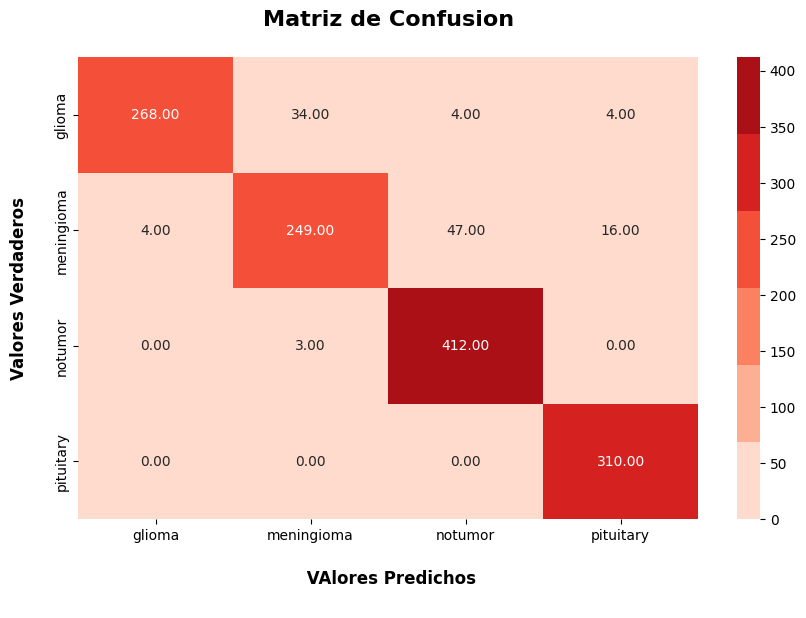

In [ ]:
confusion = confusion_matrix(y_test_actual, y_pred_actual)
plt.figure(figsize=(10,6))
fig = sns.heatmap(confusion, annot=True, fmt=".2f",cmap=cmap)

fig.set_title('Matriz de Confusion\n',
              fontdict={
                  "fontsize":16,
                  "fontweight": 'bold'
              })
fig.set_xlabel('\n VAlores Predichos\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.set_ylabel('Valores Verdaderos\n',
              fontdict={
                  "fontsize":12,
                  "fontweight": 'semibold'
              })
fig.xaxis.set_ticklabels(class_names)
fig.yaxis.set_ticklabels(class_names)
plt.show()

# Informe de Clasificacion

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Obtener las etiquetas verdaderas y las predicciones en el conjunto de pruebas
y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_pred.extend(np.argmax(predictions, axis=1))

# Obtener la información sobre las clases del conjunto de entrenamiento
class_names = class_names

# Calcular la matriz de confusión
cm = confusion_matrix(y_true, y_pred)
print("Matriz de Confusion:")
print(cm)

# Obtener el informe de clasificación
report = classification_report(y_true, y_pred, target_names=class_names)
print("Informe de Clasificacion:")
print(report)



1/1 [==============================] - 0s 159ms/step
Matriz de Confusion:
[[268  34   4   4]
 [  4 249  47  16]
 [  0   3 412   0]
 [  0   0   0 310]]
Informe de Clasificacion:
              precision    recall  f1-score   support

      glioma       0.99      0.86      0.92       310
  meningioma       0.87      0.79      0.83       316
     notumor       0.89      0.99      0.94       415
   pituitary       0.94      1.00      0.97       310

    accuracy                           0.92      1351
   macro avg       0.92      0.91      0.91      1351
weighted avg       0.92      0.92      0.92      1351



# Pruebas con Bulk Uploading

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tabulate import tabulate

def get_predictions(test_folder, model):
    img_height, img_width = 180, 180  # Tamaño de las imágenes de entrada del modelo
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Nombres de las clases

    # Función para preprocesar una imagen
    def preprocess_image(image):
        image = cv2.imread(image)  # Leer la imagen
        image = cv2.resize(image, (img_width, img_height))  # Redimensionar la imagen al tamaño de entrada del modelo

        return image

    # Obtener la lista de archivos de imágenes en la carpeta de prueba
    image_files = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if
                   file.endswith((".bmp", ".gif", ".jpeg", ".jpg", ".png"))]

    for image_file in image_files:
        image = preprocess_image(image_file)
        image = np.expand_dims(image, axis=0)  # Agregar una dimensión adicional para el batch
        predictions = model.predict(image)
        scores = tf.nn.softmax(predictions)

        img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        classes = []
        probabilities = []
        for i, class_name in enumerate(class_names):
            class_index = i
            probability = scores[0][class_index] * 100
            classes.append(class_name)
            probabilities.append("%.3f" % probability)

        # Ordenar la tabla por la columna de probabilidades en orden descendente
        sorted_data = sorted(zip(classes, probabilities), key=lambda x: float(x[1]), reverse=True)
        sorted_classes, sorted_probabilities = zip(*sorted_data)

        data = {'Class': sorted_classes, 'Probability (%)': sorted_probabilities}
        table = tabulate(data, headers='keys', tablefmt='fancy_grid')
        print(table)
        print()



1/1 [==============================] - 0s 328ms/step


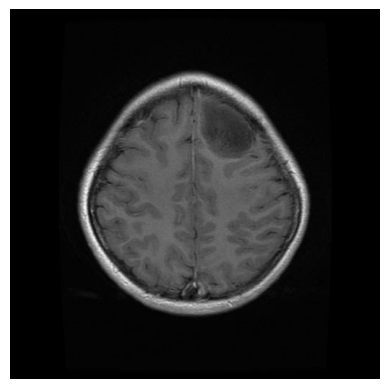

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ glioma     │            59.764 │
├────────────┼───────────────────┤
│ meningioma │            40.211 │
├────────────┼───────────────────┤
│ notumor    │             0.023 │
├────────────┼───────────────────┤
│ pituitary  │             0.002 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 57ms/step


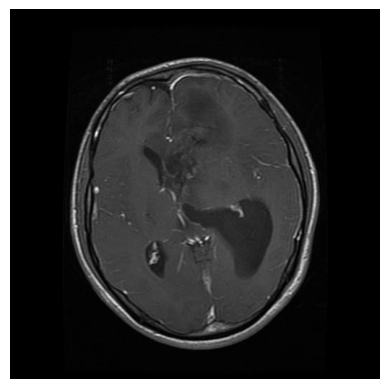

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ glioma     │            98.149 │
├────────────┼───────────────────┤
│ notumor    │             1.642 │
├────────────┼───────────────────┤
│ meningioma │             0.201 │
├────────────┼───────────────────┤
│ pituitary  │             0.008 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 56ms/step


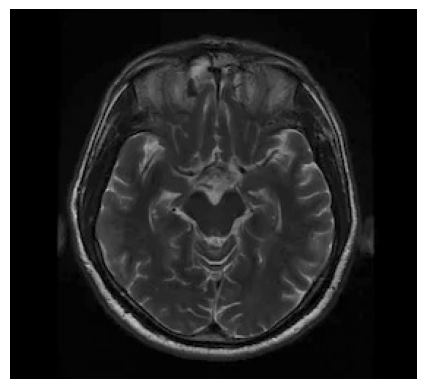

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            99.969 │
├────────────┼───────────────────┤
│ meningioma │             0.02  │
├────────────┼───────────────────┤
│ glioma     │             0.009 │
├────────────┼───────────────────┤
│ pituitary  │             0.002 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 54ms/step


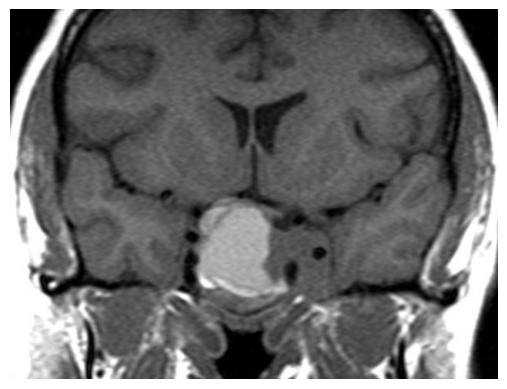

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ meningioma │            73.566 │
├────────────┼───────────────────┤
│ notumor    │            26.424 │
├────────────┼───────────────────┤
│ pituitary  │             0.009 │
├────────────┼───────────────────┤
│ glioma     │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 34ms/step


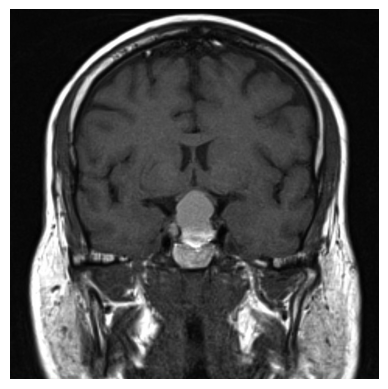

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ meningioma │            65.28  │
├────────────┼───────────────────┤
│ notumor    │            26.118 │
├────────────┼───────────────────┤
│ pituitary  │             8.602 │
├────────────┼───────────────────┤
│ glioma     │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 33ms/step


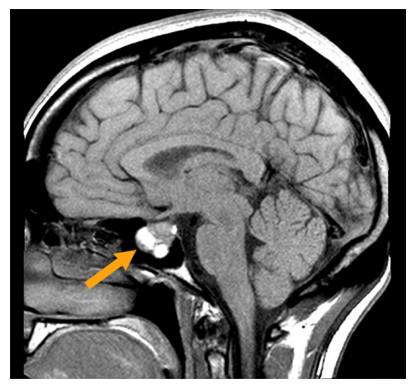

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ notumor    │            98.543 │
├────────────┼───────────────────┤
│ meningioma │             1.457 │
├────────────┼───────────────────┤
│ glioma     │             0     │
├────────────┼───────────────────┤
│ pituitary  │             0     │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 37ms/step


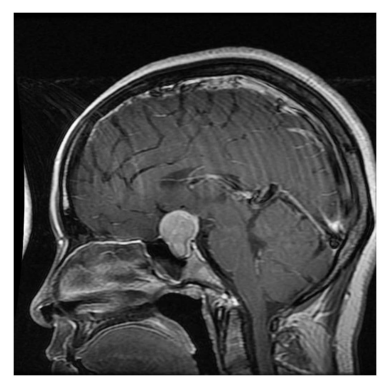

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ pituitary  │               100 │
├────────────┼───────────────────┤
│ glioma     │                 0 │
├────────────┼───────────────────┤
│ meningioma │                 0 │
├────────────┼───────────────────┤
│ notumor    │                 0 │
╘════════════╧═══════════════════╛

1/1 [==============================] - 0s 32ms/step


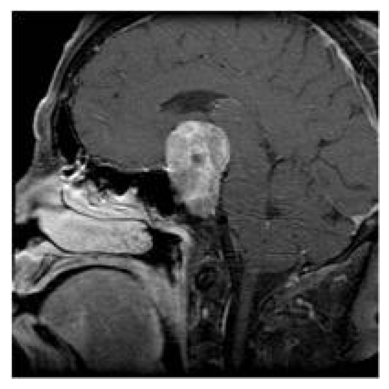

╒════════════╤═══════════════════╕
│ Class      │   Probability (%) │
╞════════════╪═══════════════════╡
│ pituitary  │            98.325 │
├────────────┼───────────────────┤
│ notumor    │             1.637 │
├────────────┼───────────────────┤
│ meningioma │             0.038 │
├────────────┼───────────────────┤
│ glioma     │             0     │
╘════════════╧═══════════════════╛



In [ ]:
test_folder = '/content/drive/MyDrive/Patient File'
model = tf.keras.models.load_model('/content/drive/MyDrive/TFM_CNNv2.h5')

get_predictions(test_folder, model)
